### Import Libraries

In [941]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

### Import Dataset

In [942]:
df = pd.read_csv("Salary_Data.csv")

In [943]:
print(df.head())

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


### Check for null values

In [944]:
print(df.isnull().values.any())
print(df.isnull().sum())

True
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


### Imputing

In [945]:
num_cols = ["Age","Years of Experience","Salary"]
cat_cols = ["Gender", "Education Level", "Job Title"]

imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])
imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer.fit_transform(df[cat_cols])

In [946]:
print(df.isnull().values.any())
print(df.isnull().sum())

False
Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


### Remove "Degree" from Education Level

In [947]:
df["Education Level"] = df["Education Level"].str.replace('degree','', case=False).str.strip()
df["Education Level"] = df["Education Level"].str.replace('phD','PhD', case=True).str.strip()

### Split Features from the Independent Variable

In [948]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

### Create Pipeline

In [949]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")
job_transformer = TargetEncoder()

num_features = ["Age", "Years of Experience"]
cat_features = ["Gender", "Education Level"]
job_features = ["Job Title"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_transformer, num_features),
        ("categorical", cat_transformer, cat_features),
        ("job", job_transformer, job_features)
    ]
)

joblib.dump(preprocessor, "salary_preprocessor.joblib")

['salary_preprocessor.joblib']

In [950]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", Lasso(alpha=0.5))])
joblib.dump(pipeline, "salary_pipeline.joblib")

['salary_pipeline.joblib']

### Splitting the Training Set and Test Set

In [951]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [952]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       Age  Gender Education Level                  Job Title  \
586   25.0  Female      Bachelor's               Data Analyst   
6180  30.0  Female      Bachelor's      Marketing Coordinator   
4146  28.0  Female      Bachelor's      Marketing Coordinator   
1715  44.0  Female             PhD  Software Engineer Manager   
2574  54.0    Male        Master's   Senior Software Engineer   
...    ...     ...             ...                        ...   
3915  39.0  Female        Master's          Marketing Manager   
1428  27.0  Female        Master's        Full Stack Engineer   
6537  25.0  Female     High School            Sales Executive   
4367  28.0  Female      Bachelor's  Junior Software Developer   
2522  31.0  Female        Master's        Full Stack Engineer   

      Years of Experience  
586                   2.0  
6180                  5.0  
4146                  2.0  
1715                 11.0  
2574                 31.0  
...                   ...  
3915                 11

### Create the Model and Fit to Training Data All With Pipeline

In [953]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Education Level']),
                                                 ('job', TargetEncoder(),
                                                  ['Job Title'])])),
                ('model', Lasso(alpha=0.5))])

### Predict on the Test Data

In [954]:
y_pred = pipeline.predict(X_test)

In [955]:
print(y_pred)

[ 98392.77100102 180287.1610468  156346.77462003 ...  72602.76743669
 102540.28469505  38517.84360371]


In [956]:
print(y_test)

3405     95000.0
2245    195000.0
5420    160000.0
6169    120000.0
1474    180000.0
          ...   
4618     90000.0
334      95000.0
2035     65000.0
6439     55000.0
3758     35000.0
Name: Salary, Length: 1341, dtype: float64


### Change this to a better format

In [957]:
y_test_series = pd.Series(y_test)
y_pred_series = pd.Series(y_pred)

In [958]:
print(y_test_series)
print(y_pred_series)

3405     95000.0
2245    195000.0
5420    160000.0
6169    120000.0
1474    180000.0
          ...   
4618     90000.0
334      95000.0
2035     65000.0
6439     55000.0
3758     35000.0
Name: Salary, Length: 1341, dtype: float64
0        98392.771001
1       180287.161047
2       156346.774620
3       127306.187721
4       167627.233988
            ...      
1336     90586.140462
1337    119539.965831
1338     72602.767437
1339    102540.284695
1340     38517.843604
Length: 1341, dtype: float64


### Create a DataFrame for Comparison

In [959]:
comparison_df = pd.concat([y_test_series.reset_index(drop=True), y_pred_series], axis=1)
comparison_df.columns = ["Actual", "Predicted"]

print(comparison_df)

        Actual      Predicted
0      95000.0   98392.771001
1     195000.0  180287.161047
2     160000.0  156346.774620
3     120000.0  127306.187721
4     180000.0  167627.233988
...        ...            ...
1336   90000.0   90586.140462
1337   95000.0  119539.965831
1338   65000.0   72602.767437
1339   55000.0  102540.284695
1340   35000.0   38517.843604

[1341 rows x 2 columns]


### Evaluate the Model

In [960]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_series.values, y_pred_series.values)
rmse = np.sqrt(mean_squared_error(y_test_series.values, y_pred_series.values))
mae = mean_absolute_error(y_test_series.values, y_pred_series.values)
r2 = r2_score(y_test_series.values, y_pred_series.values)


In [961]:
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("R-Squared Score: ", r2)

Mean Squared Error:  554732139.9899278
Root Mean Squared Error:  23552.752280570687
Mean Absolute Error:  17516.91309158701
R-Squared Score:  0.8058282435904395


### Visualize Actual vs. Predicted

Text(0.5, 1.0, 'Actual vs. Predicted Values')

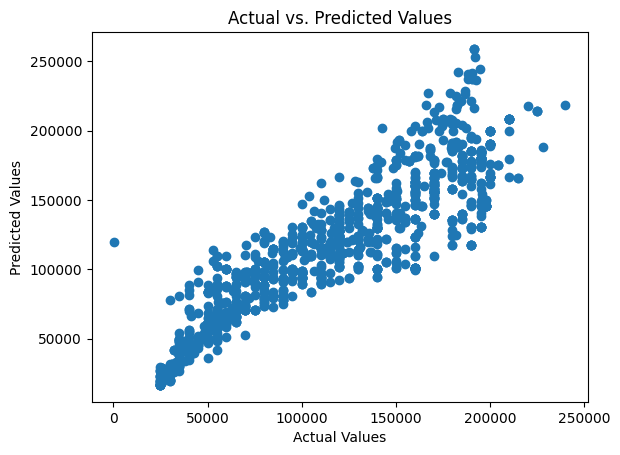

In [962]:
plt.scatter(y_test_series.values, y_pred_series.values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

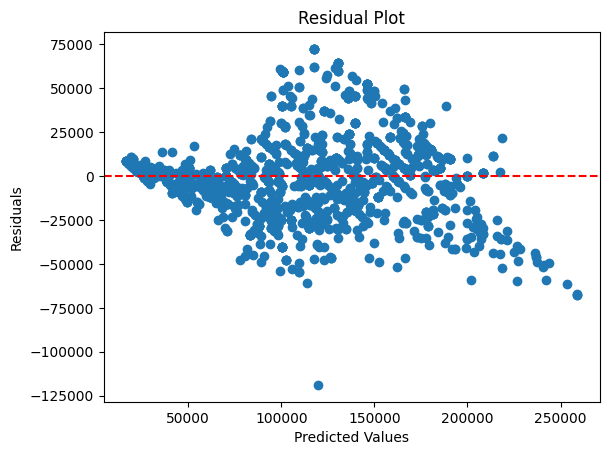

In [963]:

residuals = y_test_series.values - y_pred_series.values
plt.scatter(y_pred_series.values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Testing New Data

In [964]:
# new_data = {
#     "Age" : [23],
#     "Gender_Male" : [1],
#     "Gender_Other" : [0],
#     "Education Level_High School" : [0],
#     "Education Level_Master's" : [0],
#     "Education Level_PhD" : [0],
#     "Job Title": ["Junior Software Engineer"],
#     "Years of Experience": [1],
# }

new_data = {
    "Age" : [18],
    "Gender" : ["Male"],
    "Education Level" : ["Bachelor's"],
    "Job Title": ["Junior Software Engineer"],
    "Years of Experience": [2],
}

new_df = pd.DataFrame(new_data)


encoded_features = preprocessor.named_transformers_["categorical"].get_feature_names_out()


In [965]:
print(new_df)
print(encoded_features)

   Age Gender Education Level                 Job Title  Years of Experience
0   45   Male      Bachelor's  Junior Software Engineer                    2
['Gender_Male' 'Gender_Other' 'Education Level_High School'
 "Education Level_Master's" 'Education Level_PhD']


In [966]:
# new_df = preprocessor.transform(new_df)

print(new_df)


   Age Gender Education Level                 Job Title  Years of Experience
0   45   Male      Bachelor's  Junior Software Engineer                    2


In [967]:
new_pred = pipeline.predict(new_df)

In [968]:
print(new_pred)

[37615.15762619]
